<p align="center">
    <!--If notebook is in folder notebooks change scr by "../images/logo.png"-->
  <img width="100" height="100" src="../images/logo.png">
</p>

<div>
<h1>04. Modelos C_SEV</h1> 

Canadian Car Accidents Practice <br>
<strong>Aprendizaje Automático</strong> <br>
<strong>Master Universitario en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div>
<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---


## 4.0 Introducción

En este notebook creamos distintos modelos y realizamos una evaluación de los mismos con el objetivo de encontrar el que mejor permita clasificar los accidentes. 

Para este trabajo estamos utilizando un entorno de propósito espécifico.

In [1]:
!conda info


     active environment : ML_P1
    active env location : C:\Users\carviagu\anaconda3\envs\ML_P1
            shell level : 2
       user config file : C:\Users\carviagu\.condarc
 populated config files : 
          conda version : 4.10.3
    conda-build version : 3.21.4
         python version : 3.8.8.final.0
       virtual packages : __cuda=11.3=0
                          __win=0=0
                          __archspec=1=x86_64
       base environment : C:\Users\carviagu\anaconda3  (writable)
      conda av data dir : C:\Users\carviagu\anaconda3\etc\conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/win-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/win-64
                          https://repo.anaconda.com/pkgs/r/noarch
                          https://repo.anaconda.com/pkgs/msys2/win-64
                          https://repo.anaconda.com/pkgs/msys2/no

### 4.0.1 Estructura

## Librerías

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# MÉTRICAS
from sklearn import metrics
import scikitplot as skplt

# MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from xgboost import XGBClassifier

## Scripts

In [2]:
import sys

import sys  
sys.path.insert(0, '../scripts/')

import csv_tools
import model_tools

## 4.1 Datos
Para desarrollar este modelo básico haremos uso de los datos sin tratamiento alguno, pues nuestro objetivo es tener un punto de partida que permita valorar las mejoras realizadas con los modelos tratados. 

Por lo tanto leeremos los datos directamente:

In [3]:
full_train = pd.read_csv("../data/csev/model_6/fulltrainCSEVscal.csv")
full_test = pd.read_csv("../data/csev/model_6/fulltestCSEVscal.csv")

In [4]:
Y_train = full_train['C_SEV']
X_train = full_train.drop(['C_SEV'], axis=1)
Y_train.value_counts()

0    27794
1    27794
Name: C_SEV, dtype: int64

In [5]:
Y_test = full_test['C_SEV']
X_test = full_test.drop(['C_SEV'], axis=1)
Y_test.value_counts()

1    351139
0      6949
Name: C_SEV, dtype: int64

## 4.2 Modelado

A continuación probaremos distintos modelos con el objetivo de encontrar el más adecuado para solventar el problema en el que nos encontramos. En concreto haremos uso de 5 modelos:
* GLM (Logistic Regression)
* SVM
* Random Forest
* XGBBoost
* LightGBM

Adicionalmente tendremos un modelo base, como punto de partida para comparar las métricas.

**Métricas de evaluación**

Para poder compara los modelos haremos uso de métricas de valoración. Al encontrarnos con un problema drásticamente desbalanceado resulta muy complicado hacer uso de la mayoría de métricas disponibles. Por ello haremos uso de la matriz de confusión normalizada y de las métricas de *precission* y *recall* que permitirán analizar en detalle si el modelo es adecuado. 

No hacemos uso de métricas como el *accuracy* pues este puede ser elevado acertando la clase mayoritaria pero fallando de manera considerable la clase minoritaria. 

In [6]:
# Diccionario para guardar las predicciones realizadas por cada modelo
predictions = {}
models = {}

### 4.2.1 Modelo base
El modelo base utiliza el algoritmo de la clase mayoritaria, es decir, asginará a las predicciones el valor mayoritario del conjunto de la muestra. En nuestro caso no fallecidos (1).

In [7]:
Y_pred = pd.Series(data = [1] * len(Y_test), index = Y_test.index)

In [8]:
predictions['Base'] = Y_pred

#### Evaluación

In [9]:
model_tools.accuracy(Y_test, Y_pred)

0.98059415562655

Matriz de confusión
[[     0   6949]
 [     0 351139]]
Matriz de confusión normalizada
[[0. 1.]
 [0. 1.]]


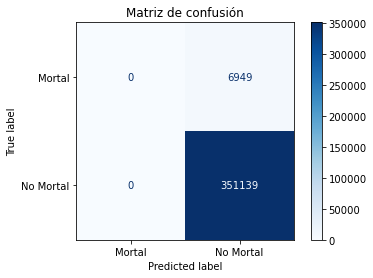

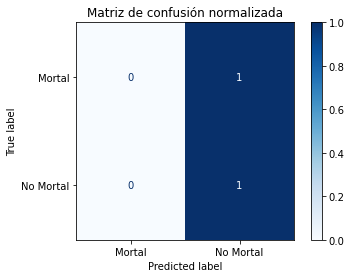

In [10]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]

model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

< < COMENTARIO > >

### 4.2.2 Modelo GLM 
Para el modelo GLM utilizaremos como clasificador un Regresor Logístico.

In [11]:
model = LogisticRegression()

In [12]:
model.fit(X_train, Y_train)

LogisticRegression()

In [13]:
Y_pred = model.predict(X_test)

In [14]:
predictions['GLM'] = Y_pred
models['GLM'] = model

In [15]:
file_name = "../models/glm_fmodel.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [16]:
model_tools.accuracy(Y_test, Y_pred)

0.6030612586850159

Matriz de confusión
[[  4888   2061]
 [140078 211061]]
Matriz de confusión normalizada
[[0.70341056 0.29658944]
 [0.39892464 0.60107536]]


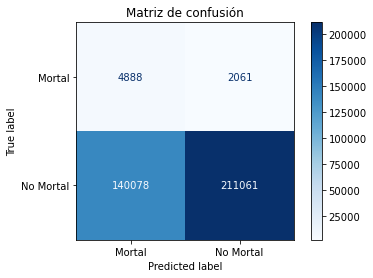

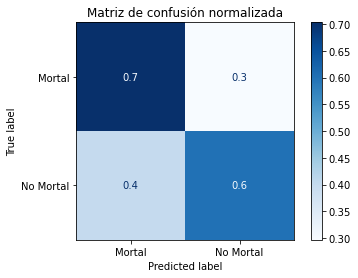

In [17]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

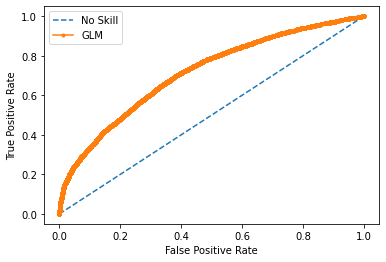

In [28]:
pred_prob = model.predict_proba(X_test)
yhat = pred_prob[:,1]
model_tools.roc_curve(Y_test, yhat, 'GLM')

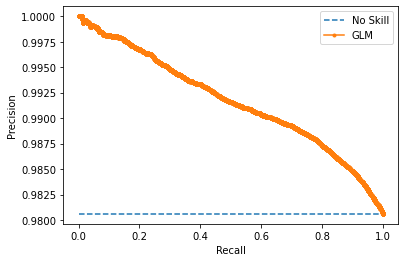

In [35]:
precision, recall, thresholds = metrics.precision_recall_curve(Y_test, yhat)
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='GLM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

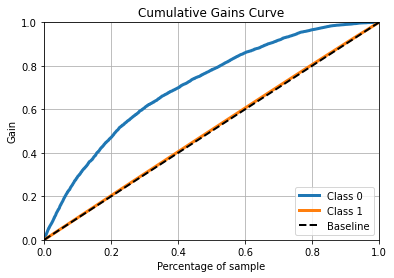

In [30]:
skplt.metrics.plot_cumulative_gain(Y_test, pred_prob)
plt.show()

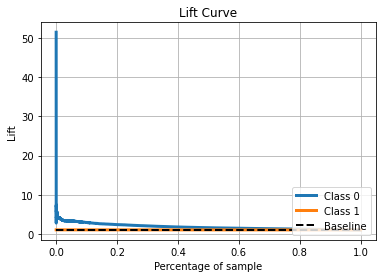

In [33]:
skplt.metrics.plot_lift_curve(Y_test, pred_prob)
plt.show()

< < COMENTARIO > >

### 4.2.3 Modelo SVM

In [20]:
svc = SVC(gamma = 'auto')

In [21]:
#svc.fit(X_train, Y_train)

In [22]:
#Y_pred = svc.predict(X_test)

In [23]:
predictions['SVM'] = Y_pred
models['SVM'] = model

In [24]:
#file_name = "../models/svm_fmodel.sav"
#pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [25]:
model_tools.accuracy(Y_test, Y_pred)

0.6030612586850159

Matriz de confusión
[[  4888   2061]
 [140078 211061]]
Matriz de confusión normalizada
[[0.70341056 0.29658944]
 [0.39892464 0.60107536]]


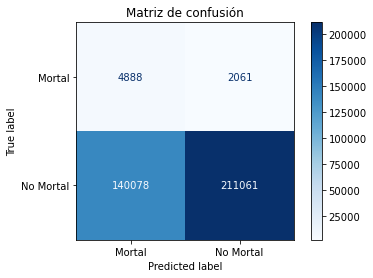

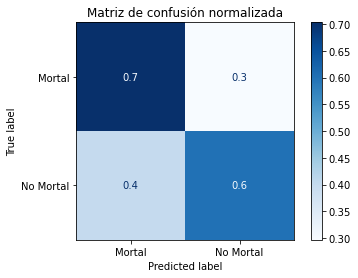

In [26]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                           ['Mortal', 'No Mortal'])

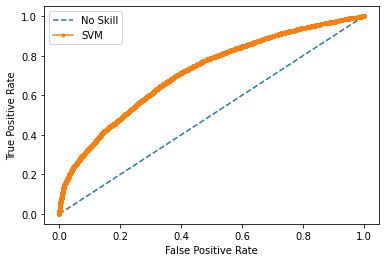

In [27]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'SVM')

< < COMENTARIO > >

### 4.2.4 Modelo RandomForest

In [28]:
model = RandomForestClassifier()

In [29]:
model.fit(X_train, Y_train)

RandomForestClassifier()

In [30]:
Y_pred = model.predict(X_test)

In [31]:
predictions['Random Forest'] = Y_pred
models['Random Forest'] = model

In [32]:
file_name = "../models/rf_fmodel.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [33]:
model_tools.accuracy(Y_test, Y_pred)

0.6355057974576082

Matriz de confusión
[[  4797   2152]
 [128369 222770]]
Matriz de confusión normalizada
[[0.69031515 0.30968485]
 [0.36557887 0.63442113]]


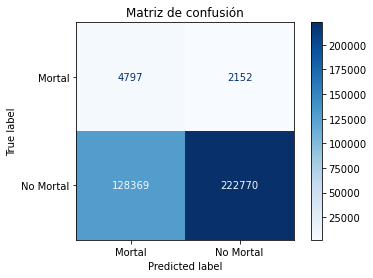

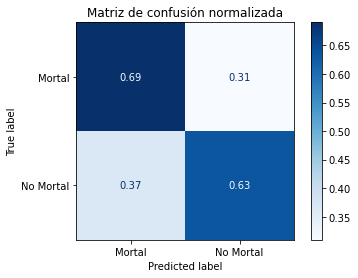

In [34]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

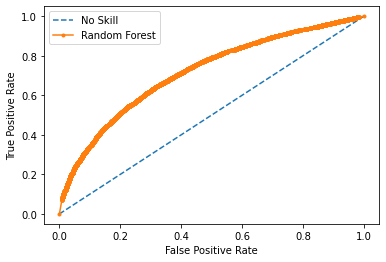

In [35]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'Random Forest')

< < COMENTARIO > >

### 4.2.5 Modelo XGBBoost

In [36]:
model = XGBClassifier(use_label_encoder=False, eval_metric="error") # Default values

In [37]:
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [38]:
Y_pred = model.predict(X_test)

In [39]:
predictions['XGB'] = Y_pred
models['XGB'] = model

In [40]:
file_name = "../models/xgb_fmodel.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [41]:
model_tools.accuracy(Y_test, Y_pred)

0.6577237997363776

Matriz de confusión
[[  4908   2041]
 [120524 230615]]
Matriz de confusión normalizada
[[0.70628867 0.29371133]
 [0.34323729 0.65676271]]


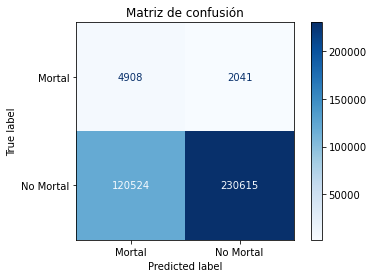

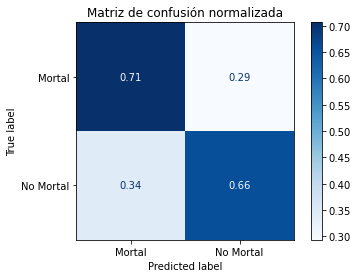

In [42]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

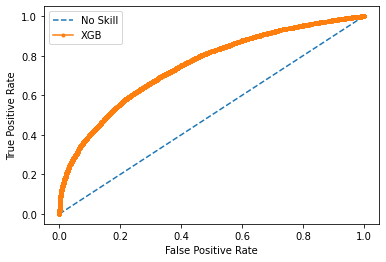

In [43]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'XGB')

< < COMENTARIO > >

### 4.2.6 Modelo LigthGBM

In [44]:
model = lightgbm.LGBMClassifier()

In [45]:
model.fit(X_train, Y_train)

LGBMClassifier()

In [46]:
Y_pred = model.predict(X_test)

In [47]:
predictions['LightGBM'] = Y_pred
models['LightGBM'] = model

In [48]:
file_name = "../models/lgbm_fmodel.sav"
pickle.dump(model, open(file_name, "wb"))

#### Evaluación

In [49]:
model_tools.accuracy(Y_test, Y_pred)

0.6604298384754586

Matriz de confusión
[[  4893   2056]
 [119540 231599]]
Matriz de confusión normalizada
[[0.70413009 0.29586991]
 [0.34043498 0.65956502]]


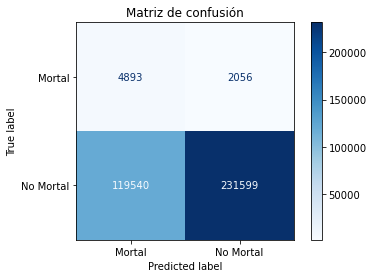

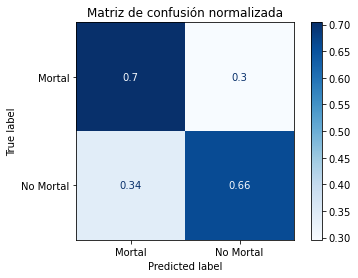

In [50]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
model_tools.confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['Mortal', 'No Mortal'])

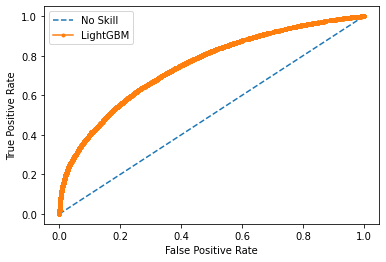

In [51]:
pred_prob = model.predict_proba(X_test)[:,1]
model_tools.roc_curve(Y_test, pred_prob, 'LightGBM')

< < COMENTARIO > >

## 4.3 Valoración
Procedemos a valorar los modelos de forma conjunta para poder tomar al decisión de cual escoger.

Analizamos las curvas ROC de los modelos. Primero realizamos una representación básica que incluya el modelo base.

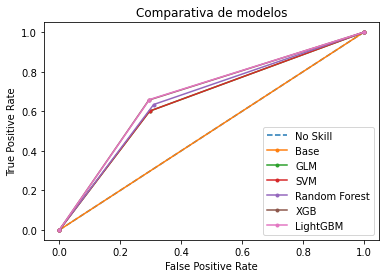

In [52]:
# Curva por defecto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Curva de cada modelo
for key in predictions:
    # calculate roc curves (no prob)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[key])
    plt.plot(fpr, tpr, marker='.', label=key)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa de modelos')
plt.legend()

Observamos que el modelo base, es un modelo sin ningún tipo de aprendizaje por lo que su curva es igual a un modelo *No Skill*. Y que los modelos Boost (XGB y LightGBM) presentan unas curvas más próximas a un modelo con un mejor entrenamiento.

Ahora representaremos la curva con probabilidades de predicción.

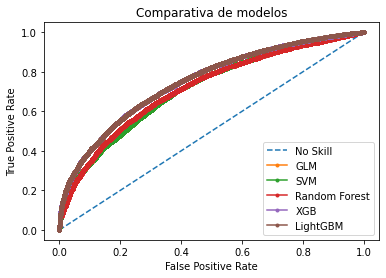

In [53]:
# Curva por defecto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

# Curva de cada modelo
for key in models:
        yhat = models[key].predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, yhat)
        plt.plot(fpr, tpr, marker='.', label=key)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa de modelos')
plt.legend()

Parece que los modelos Boost serán los mejores. 

Ahora representaremos sus valores de precision y recall.

In [54]:
scores = pd.DataFrame(data = predictions.keys(), columns = ['Models'], index = [0, 1, 2, 3, 4, 5])

pres = list()
rec = list()
roc = list()

for key in predictions:
    # Precision
    pres.append(metrics.precision_score(Y_test, predictions[key], zero_division = 0.0, labels=[0], average='weighted'))
    # Recall
    rec.append(metrics.recall_score(Y_test, predictions[key], zero_division = 0.0, labels=[0], average='weighted'))
    # RocAUC
    if (key == 'Base'):
        roc.append(0.00)
    else:
        roc.append(metrics.roc_auc_score(Y_test, models[key].predict_proba(X_test)[:,1]))

scores['Precision'] = pres
scores['Recall'] = rec
scores['Roc_Auc'] = roc

scores

,Models,Precision,Recall,Roc_Auc
0,Base,0.000000,0.000000,0.000000
1,GLM,0.033718,0.703411,0.715657
2,SVM,0.033718,0.703411,0.715657
3,Random Forest,0.036023,0.690315,0.717398
4,XGB,0.039129,0.706289,0.750746
5,LightGBM,0.039322,0.704130,0.751358


A la hora de valorar los modelos la precision no es muy útil pues el problema está desbalanceado, por lo que haremos uso del recall como métrica principal. Paralelamente utilizamos el ROC_AUC, es decir, el área de la curva ROC, observamos que es ligeramente superior en el LightGBM, pues este es más equilibrado, sin embargo nos interesa que el modelo prediga mejor los casos de fallecimientos.

## 4.4 Elección y conclusiones

MODELO GANADOR

PQ (RESUMIR LO EXPUESTO ANTERIORMENTE)

QUE VAMOS A REALIZAR CON EL

---

<div style='text-align:center'>Elaborado por Álvaro Serrano del Rincón (<i>a.serranodelrincon@cunef.edu</i>)</div> 
<div style='text-align:center'>y Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div> 